## This notebook shows how to use Orchestrator APIs for user experiments

In [13]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

In [15]:
slice_name='Slice-fp'

In [ ]:
fabric_rc_location=os.environ['HOME']+"/work/fabric_config/fabric_rc"
if os.path.exists(fabric_rc_location):
    with open(fabric_rc_location, 'r') as f:
        for line in f:
            if line.startswith('export'):
                os.environ[line.split('=')[0].split('export')[1].strip()] = line.split('=')[1].strip()

In [ ]:
ssh_key_file_priv=os.environ["FABRIC_SLICE_PRIVATE_KEY_FILE"]
ssh_key_file_pub=os.environ["FABRIC_SLICE_PUBLIC_KEY_FILE"]

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [16]:
slice_manager = SliceManager(project_name="FABRIC Staff")

### Orchestrator API example to query for available resources

In [17]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: LBNL [Site]
	Components:
	Site Interfaces:
		LBNL_RENC: TrunkPort { bw: 100/100 Gbps}
		LBNL_UKY: TrunkPort { bw: 100/100 Gbps}
UKY [Site] : { cpu: 6/6 , core: 190/192 , ram: 1,530/1,536 G, disk: 60,590/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 9/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 1/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
		UKY_RENC: TrunkPort { bw: 100/100 Gbps}
		HundredGigE0/0/0/15: TrunkPort { bw: 100/100 Gbps}
		UKY_LBNL: TrunkPort { bw: 100/100 Gbps}
RENC [Site] : { cpu: 6/6 , core: 190/192 , ram: 1,530/1,536 G, disk: 60,590/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { 

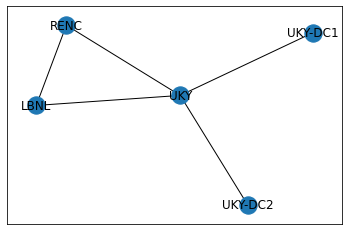

In [18]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

In [19]:
port_name="port+uky-data-sw:HundredGigE0/0/0/15"

In [20]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, Labels, ComponentType, ComponentModelType, ServiceType, Labels
from ipaddress import IPv4Network

# Create topology
t = ExperimentTopology()

# Set capacities
cap = Capacities(core=2, ram=6, disk=10)


n3 = t.add_node(name='n3', site='RENC', capacities=cap, image_type='qcow2', image_ref='default_rocky_8')
n3.add_component(name='nic1', model_type=ComponentModelType.SmartNIC_ConnectX_5)
n3.interface_list[0].labels = Labels.update(n3.interface_list[0].labels, ipv4="192.168.10.6")

t.add_port_mirror_service(name='pm1', from_interface_name=port_name,
                          to_interface=n3.interface_list[0])

    
# Generate Slice Graph
slice_graph = t.serialize()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name=slice_name, slice_graph=slice_graph, ssh_key=ssh_key_pub)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
    slice_id = reservations[0].slice_id
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "69b2535a-58ca-4407-9828-710506d4d69f",
    "lease_end": "2022-04-16 00:28:54",
    "lease_start": "2022-04-15 00:28:54",
    "pending_state": "None_",
    "reservation_id": "773d182f-38e6-4bfc-8694-87e19e75da02",
    "reservation_state": "Unknown",
    "slice_id": "62452b2a-38e9-4928-8d37-a9b9585e5f92"
}, {
    "graph_node_id": "7b9632b0-74e3-480f-bebc-2046ff1946f4",
    "lease_end": "2022-04-16 00:28:54",
    "lease_start": "2022-04-15 00:28:54",
    "pending_state": "None_",
    "reservation_id": "7169dc77-a7c8-415d-927a-5890c0dcf253",
    "reservation_state": "Unknown",
    "slice_id": "62452b2a-38e9-4928-8d37-a9b9585e5f92"
}]


## Query Slices

In [21]:
status, slices = slice_manager.slices()
print("Response Status {}".format(status))
if status == Status.OK:    
    slice_object=list(filter(lambda s: s.slice_id == slice_id, slices))[0]
    print(slice_object)
else:
    print(f"Failure: {slices}")

Response Status Status.OK
{
    "graph_id": "0e3e2ae7-7236-463b-a288-d63eab08078a",
    "lease_end": "2022-04-16 00:28:54",
    "slice_id": "62452b2a-38e9-4928-8d37-a9b9585e5f92",
    "slice_name": "Slice-fp",
    "slice_state": "Configuring"
}


## Query Slivers

In [23]:
status, slivers = slice_manager.slivers(slice_object=slice_object)

print("Response Status {}".format(status))
if status == Status.OK:
    for s in slivers:
        print("=====================")
        print("ReservationId {}".format(s.reservation_id))
        print("State         {}".format(s.reservation_state))
        print("Pending       {}".format(s.pending_state))
        print("Join State    {}".format(s.join_state))
        print("Sliver Type   {}".format(s.sliver_type))
        print("Sliver        {}".format(s.sliver))
        if s.sliver_type == "NodeSliver":
            for d in s.sliver.attached_components_info.devices.values():
                print("-------------------------")
                print("COMPONENT        {}".format(d))
                print("-------------------------")
        else:
            for d in s.sliver.interface_info.interfaces.values():
                print("-------------------------")
                print("INTERFACE        {}".format(d))
                print("-------------------------")
                
        print("Notices       {}".format(s.notices))
        print("=====================")
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
ReservationId 7169dc77-a7c8-415d-927a-5890c0dcf253
State         Active
Pending       None_
Join State    NoJoin
Sliver Type   NetworkServiceSliver
Sliver        {'layer': 'L2', 'mirror_direction': 'Both', 'mirror_port': 'port+uky-data-sw:HundredGigE0/0/0/15', 'name': 'pm1', 'node_map': "('e9e6042b-d9bf-4dbf-8278-8537c9b615ac', 'node+renc-data-sw:ip+192.168.11.3-ns')", 'reservation_info': '{"error_message": "", "reservation_id": "7169dc77-a7c8-415d-927a-5890c0dcf253", "reservation_state": "Active"}', 'site': 'RENC', 'type': 'PortMirror'}
-------------------------
INTERFACE        {'capacities': '{ bw: 25 Gbps, unit: 1 }', 'label_allocations': '{ ipv4: 192.168.10.6, local_name: TwentyFiveGigE0/0/0/23/0, device_name: renc-data-sw}', 'labels': '{ ipv4: 192.168.10.6, local_name: TwentyFiveGigE0/0/0/23/0, device_name: renc-data-sw}', 'name': 'n3-nic1-p1', 'node_map': "('e9e6042b-d9bf-4dbf-8278-8537c9b615ac', 'port+renc-data-sw:TwentyFiveGigE0/0/0/23/0')", 'type': '

## Delete Slice

In [12]:
status, result = slice_manager.delete(slice_object=slice_object)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
